# Weather Dataset Preprocessing

A dataset that has a collection of weather observations from the city of Aarhus, spanning from Feb through Sept in 2014 excluding July. 

In [6]:
import tarfile
import pandas as pd
import os
import requests
import json
from pathlib import Path
import matplotlib.pyplot as plt
import zipfile
from io import BytesIO

In [23]:
# Download tar file
response1 = requests.get('http://iot.ee.surrey.ac.uk:8080/datasets/weather/feb_jun_2014/raw_weather_data_aarhus.tar.gz')
response2 = requests.get('http://iot.ee.surrey.ac.uk:8080/datasets/weather/aug_sep_2014/raw_weather_data_aug_sep_2014.zip')

In [24]:
weather1_df = []
with tarfile.open(fileobj=BytesIO(response1.content), mode='r:gz') as tar:
    variables = tar.getnames() # saves the names of the files within the tar.gz

    all_data = []

    for variable in variables:
        extracted_file = tar.extractfile(variable)
        file_content = extracted_file.read().decode('utf-8')

        # Split content into multiple JSON objects (each file line is a json object)
        json_objects = file_content.strip().split('\n')

        variable_name = Path(variable).stem
        variable_data = []

        for obj in json_objects:
            # Parse each JSON object and convert it to a dataframe
            data_dict = json.loads(obj)
            df = pd.DataFrame(list(data_dict.items()), columns=['Datetime', variable_name])
                
            # Convert the Datetime column to a pandas datetime format and use it as the index
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            df.set_index('Datetime', inplace=True)
                
            # Append each line to the variable dataframe
            variable_data.append(df)
        variable_final = pd.concat(variable_data)
        all_data.append(variable_final)
        
    # did outer joint to keep all indicies and fill NaN values for missing data
    weather1_df = pd.concat(all_data, axis=1, join='outer')
        
weather1_df.head()

,dewptm,pressurem,wdird,tempm,vism,wspdm,hum
Datetime,,,,,,,
2014-02-13 06:20:00,2.0,989,170,3.0,10.0,16.7,93
2014-02-13 13:50:00,1.0,989,200,7.0,10.0,14.8,66
2014-02-13 06:00:00,1,990,170,2,11,13.0,91
2014-02-13 03:00:00,1,992,150,3,8,20.4,84
2014-02-13 13:00:00,1,990,190,6,24,20.4,62


In [30]:
weather2_df = []
with zipfile.ZipFile(BytesIO(response2.content), mode='r') as zip_ref:
    # Get the list of files in the zip archive
    variables = [file for file in zip_ref.namelist() if file.endswith('.txt') and not file.startswith('__MACOSX')]
    all_data = []

    for variable in variables:
        # Extract the file content from the zip file
        with zip_ref.open(variable) as extracted_file:
            file_content = extracted_file.read().decode('utf-8')

            # Split content into multiple JSON objects (each line is a JSON object)
            json_objects = file_content.strip().split('\n')

            # Use the file name (without extension) as the variable name
            variable_name = Path(variable).stem
            variable_data = []

            for obj in json_objects:
                # Parse each JSON object and convert it into a DataFrame
                data_dict = json.loads(obj)
                df = pd.DataFrame(list(data_dict.items()), columns=['Datetime', variable_name])
                    
                # Convert the 'Datetime' column to pandas datetime format and set it as the index
                df['Datetime'] = pd.to_datetime(df['Datetime'])
                df.set_index('Datetime', inplace=True)
                    
                # Append each DataFrame to the list of variable data
                variable_data.append(df)
                
            # Concatenate the DataFrames for this variable
            variable_final = pd.concat(variable_data)
            all_data.append(variable_final)

    # Concatenate all DataFrames with an outer join to match indices (Datetime)
    weather2_df = pd.concat(all_data, axis=1, join='outer')
        
weather2_df = pd.DataFrame(weather2_df)  # Convert to DataF
# Print the final combined DataFrame
print(weather2_df)

                    dewptm hum pressurem tempm wdird wspdm
Datetime                                                  
2014-08-01 01:00:00     13  64      1012    18   210   7.4
2014-08-01 13:00:00     15  53      1013    22   180  11.1
2014-08-01 01:20:00   13.0  73      1012  18.0   210   7.4
2014-08-01 13:20:00   13.0  57      1013  22.0   180  14.8
2014-08-01 13:50:00   12.0  47      1013  24.0   170  14.8
...                    ...  ..       ...   ...   ...   ...
2014-09-30 18:00:00      9  63      1025    14   100   9.3
2014-09-30 04:00:00     11  84      1024    13   100   5.6
2014-09-30 03:20:00   12.0  88      1023  14.0   100   3.7
2014-09-30 04:20:00   12.0  88      1023  14.0    80   7.4
2014-09-30 18:20:00    9.0  72      1025  14.0   100  11.1

[4357 rows x 6 columns]


In [31]:
# Saving data for EDA
concat_df = pd.concat([weather1_df, weather2_df])
numeric_cols = ['dewptm', 'pressurem', 'wdird', 'tempm', 'vism', 'wspdm', 'hum']
for col in numeric_cols:
    concat_df[col] = pd.to_numeric(concat_df[col],  errors="coerce")

print(concat_df.describe())

            dewptm    pressurem        wdird        tempm         vism  \
count  8207.000000  8203.000000  8146.000000  8207.000000  8207.000000   
mean      4.229073  1013.638059   182.431868     9.061167  -390.753741   
std       3.979373     9.515477    89.646687     4.830610  1969.870626   
min      -9.000000   986.000000     0.000000    -3.000000 -9999.000000   
25%       2.000000  1007.000000   110.000000     5.000000     8.000000   
50%       3.000000  1014.000000   190.000000     8.000000    10.000000   
75%       7.000000  1020.000000   260.000000    12.000000    10.000000   
max      15.000000  1038.000000   360.000000    25.000000    50.000000   

             wspdm          hum  
count  8175.000000  8207.000000  
mean     11.953700    71.157914  
std     111.066814    16.132295  
min   -9999.000000    12.000000  
25%       7.400000    61.000000  
50%      11.100000    75.000000  
75%      18.500000    84.000000  
max      64.800000   100.000000  


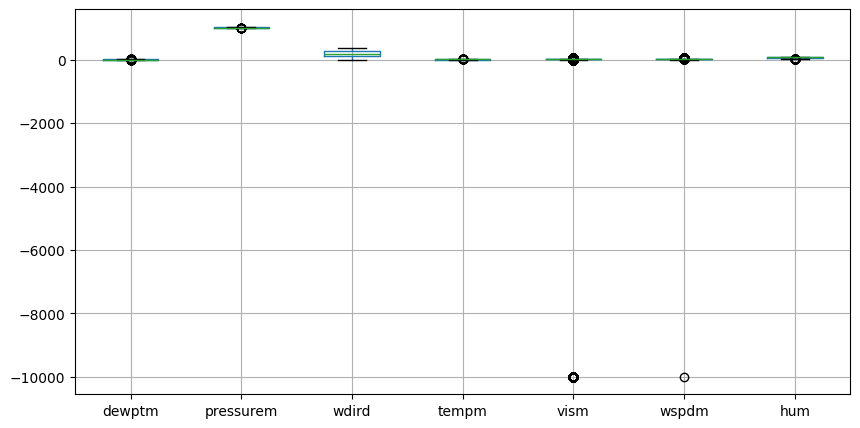

In [32]:
#identifying outliers
concat_df.boxplot(column=numeric_cols, figsize=(10,5))
plt.show()

vism     10.0
wspdm    11.1
dtype: float64


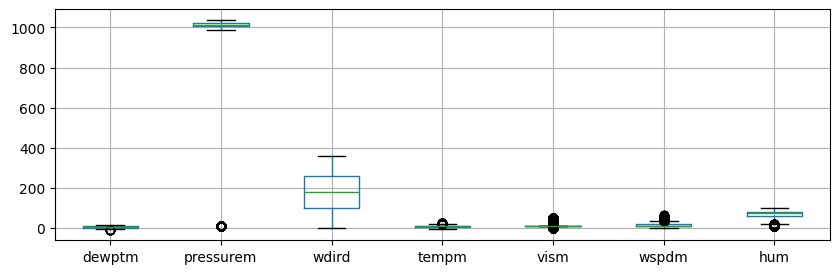

In [33]:
# Removing vism and wspdm Outliers
cols = ['vism', 'wspdm']
median_values = concat_df[cols].median()
print(median_values)
bad_reading = -9990
concat_df.loc[concat_df['vism'] < -9990] = median_values['vism']
concat_df.loc[concat_df['wspdm'] < -9990] = median_values['wspdm']

concat_df.boxplot(column=numeric_cols, figsize=(10,3))
plt.show()

In [34]:

concat_df.to_csv("../data/aarhus_weather_data_combined.csv")